In [54]:
from gpt import GPT
from distgen import Generator
from distgen.plot import plot_dist2d
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update(
    {"font.size": 20, "lines.linewidth": 2.5, "figure.figsize": (10, 6)}
)
from scipy.io import loadmat

In [20]:
# Import experimental data
exp_data = loadmat(
    "/nfs/bbl/online/epics/ScriptsB24/SolenoidScan/data_03-25-2021/500um/s.mat"
)

<disgten.Generator with input: 
n_particle: 10000
output:
  file: rad.uniform.out.txt
  type: gpt
r_dist:
  max_r:
    units: mm
    value: 1.2
  min_r:
    units: mm
    value: 0
  type: radial_uniform
random_type: hammersley
start:
  MTE:
    units: meV
    value: 500
  type: cathode
t_dist:
  max_t:
    units: ps
    value: 150
  min_t:
    units: ps
    value: -150
  type: uniform
total_charge:
  units: pC
  value: 15
transforms:
  order:
  - t1
  t1:
    delta:
      units: keV/c
      value: 506
    type: translate pz

>


<AxesSubplot:xlabel='$t$ (ps)', ylabel='$p_z$ (keV/c)'>

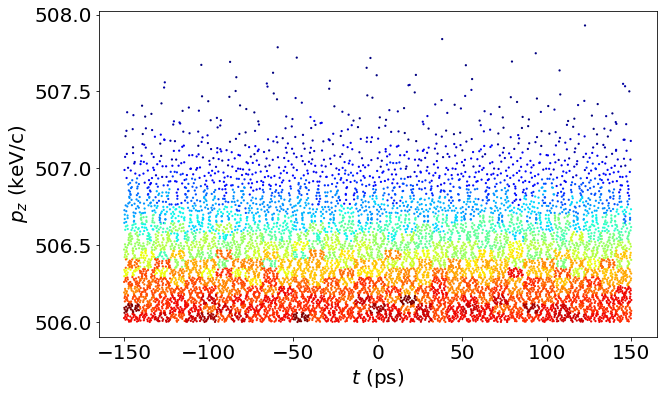

In [189]:
# Uniform initial distribution
gen = Generator("beamline/uniform.in.yaml", verbose=0)
gen["start:MTE:value"] = 500
gen["r_dist:max_r:value"] = 1.2

transpz = {"type": "translate pz", "delta": {"value": 506, "units": "keV/c"}}
gen.input["transforms"] = {"t1": transpz, "order": ["t1"]}

gen.run()
beam = gen.beam()
print(gen)
plot_dist2d(beam, "t", "ps", "pz", "keV/c")

0.0
0.41111111111111115
0.8222222222222223
1.2333333333333334
1.6444444444444446
2.055555555555556
2.466666666666667
2.877777777777778
3.288888888888889
3.7


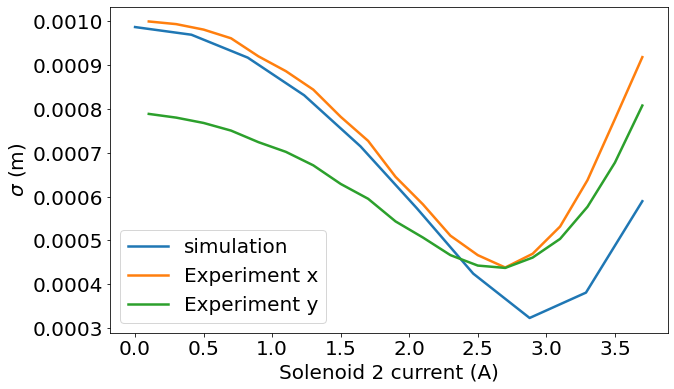

In [190]:
G = GPT(input_file="beamline/beamline_screen3_only.in", initial_particles=gen.particles)

# in case not using distgen
radius = 2e-3
MTE = 10  # meV
emit = radius / 2 * np.sqrt(MTE * 1e-3 / 511e3)
G.set_variables({"radius": radius, "emit": emit})
# set scan range
sol2_current = np.linspace(0, 3.7, num=10)
sig_x = np.array([])

# Start loop
for isol in sol2_current:
    print(isol)
    set_variables = G.set_variables({"sol02_current": isol})
    G.run()
    sig_x = np.append(sig_x, G.stat("sigma_x", "screen")[-1])

# Plot
plt.plot(sol2_current, sig_x, label="simulation")
plt.plot(exp_data["sol"], np.transpose(exp_data["sx"]), label="Experiment x")
plt.plot(exp_data["sol"], np.transpose(exp_data["sy"]), label="Experiment y")
plt.xlabel("Solenoid 2 current (A)")
plt.ylabel(r"$\sigma$ (m)")
plt.legend()

0
1
2


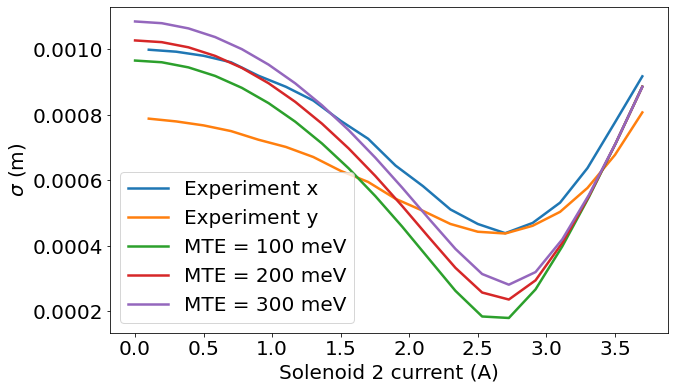

In [247]:
## Sol2 current vs beam size at multiple MTEs

gen["total_charge:value"] = 1e-3  # 3 uA
# Set radius
gen["r_dist:max_r:value"] = 1.8  # for uniform dist

# Set scan range
sol2_current = np.linspace(0, 3.7, num=20)
MTE_arr = np.linspace(100, 300, num=3)
sig_x = np.zeros((len(MTE_arr), len(sol2_current)))

# run loop
for MTE_ind in range(0, len(MTE_arr)):
    gen["start:MTE:value"] = float(MTE_arr[MTE_ind])
    gen.run()
    G = GPT(
        input_file="beamline/beamline_screen3_only.in",
        initial_particles=gen.particles,
        verbose=False,
    )
    # G.set_variables({'space_charge': 1}) # space charge on
    print(MTE_ind)
    for cur_ind in range(0, len(sol2_current)):
        G.set_variables({"sol02_current": sol2_current[cur_ind]})
        G.run()
        sig_x[MTE_ind, cur_ind] = G.stat("sigma_x", "screen")[-1]


# Plot
plt.plot(exp_data["sol"], np.transpose(exp_data["sx"]), label="Experiment x")
plt.plot(exp_data["sol"], np.transpose(exp_data["sy"]), label="Experiment y")

for MTE_ind in range(0, len(MTE_arr)):
    plt.plot(sol2_current, sig_x[MTE_ind], label=f"MTE = {MTE_arr[MTE_ind]:.0f} meV")

plt.xlabel("Solenoid 2 current (A)")
plt.ylabel(r"$\sigma$ (m)")
plt.legend()

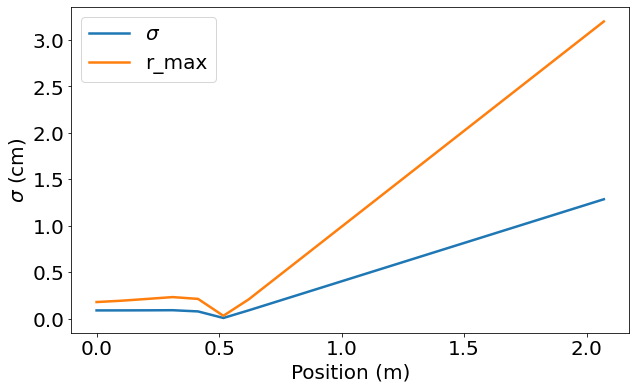

In [250]:
gen["start:MTE:value"] = 200
gen["r_dist:max_r:value"] = 1.8  # for uniform dist
gen.run()
G = GPT(input_file="beamline/beamline_screen3_only.in", initial_particles=gen.particles)
G.set_variables({"sol02_current": 5.0})
G.run()

# Plot
plt.plot(
    G.stat("mean_z", "screen"), G.stat("sigma_x", "screen") * 100, label=r"$\sigma$"
)
plt.plot(G.stat("mean_z", "screen"), G.stat("max_r", "screen") * 100, label="r_max")
plt.xlabel("Position (m)")
plt.ylabel(r"$\sigma$ (cm)")
plt.legend()

Text(0, 0.5, 'y (cm)')

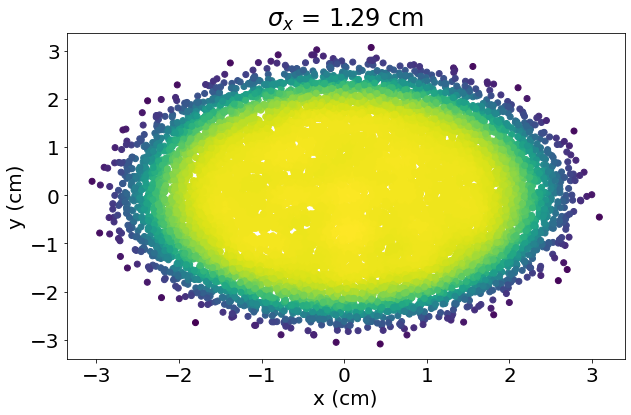

In [251]:
screen = G.screen[-1]
x = screen["x"] * 100
y = screen["y"] * 100
sig_x = screen["sigma_x"] * 100

# Calculate the point density
xy = np.vstack([x,y])
from scipy.stats import gaussian_kde
z = gaussian_kde(xy)(xy)

plt.title(fr"$\sigma_x$ = {sig_x:.3g} cm")
plt.scatter(x, y, c=z)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")